In [ ]:
# Section 1

import requests
from scipy.io import arff
import io

def load_arff_from_github(filename):
    """
    Load an ARFF file from the GitHub repository given the filename.

    Parameters:
    filename (str): The name of the ARFF file to be loaded (e.g., '2d-3c-no123.arff').

    Returns:
    tuple: A tuple containing the data and meta information from the ARFF file.
    """
    base_url = 'https://raw.githubusercontent.com/deric/clustering-benchmark/fc7aba73c873b0e017dd3a6d7113b1cb2ede118a/src/main/resources/datasets/artificial/'
    url = base_url + filename

    try:
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            content = response.content.decode('utf-8')  # Decode the content to a string
            data, meta = arff.loadarff(io.StringIO(content))  # Use StringIO to read the string as a file
            print(f"{filename} loaded successfully.")
            return data, meta
        else:
            print(f"Failed to download the file: {filename}. HTTP Status Code: {response.status_code}")
            return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [ ]:
# Section 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import time
from scipy.io import arff
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import Birch as SklearnBirch

class SimpleClusterNode:
    def __init__(self, initial_point):
        self.centroid = np.array(initial_point)
        self.points_sum = np.array(initial_point)
        self.points_count = 1

    def update(self, new_point):
        self.points_sum += new_point
        self.points_count += 1
        self.centroid = self.points_sum / self.points_count

class SimpleBIRCH:
    def __init__(self, threshold, branching_factor):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.clusters = []

    def fit(self, X):
        for point in X:
            self._add_point(point)

    def _add_point(self, point):
        closest_cluster, distance = self._find_closest_cluster(point)

        if closest_cluster is not None and distance < self.threshold:
            closest_cluster.update(point)
        else:
            if len(self.clusters) < self.branching_factor:
                self.clusters.append(SimpleClusterNode(point))

    def _find_closest_cluster(self, point):
        if not self.clusters:
            return None, float('inf')

        distances = [np.linalg.norm(cluster.centroid - point) for cluster in self.clusters]
        min_distance = min(distances)
        return self.clusters[distances.index(min_distance)], min_distance

    def predict(self, X):
        labels = []
        for point in X:
            cluster, _ = self._find_closest_cluster(point)
            labels.append(self.clusters.index(cluster))
        return labels

<ipython-input-32-2a82bd159f21>:274: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', np.unique(labels).size).colors


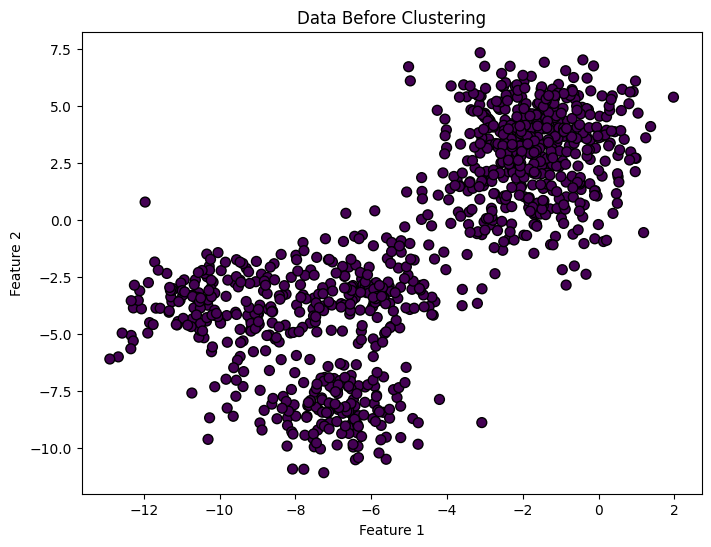

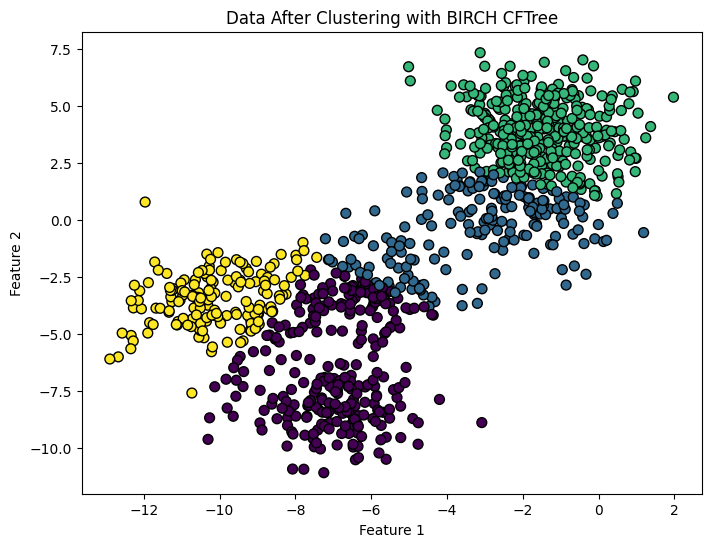

Execution time:  2.0955 seconds



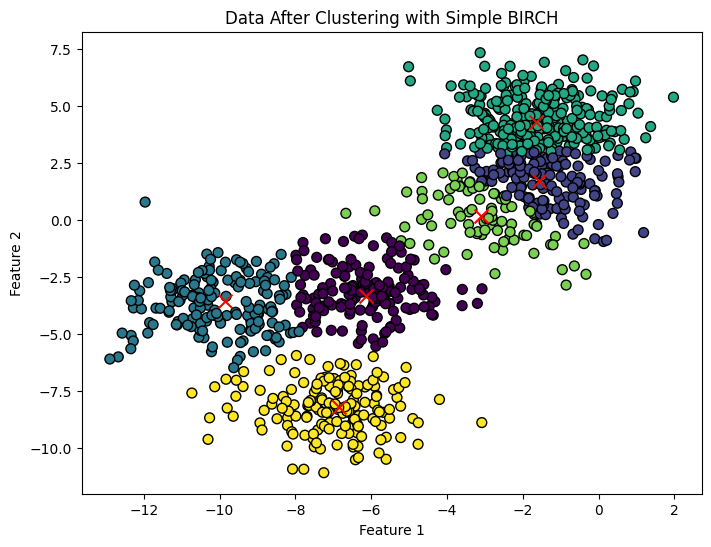

Execution time for SimpleBirch:  0.1093 seconds



<ipython-input-32-2a82bd159f21>:274: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', np.unique(labels).size).colors


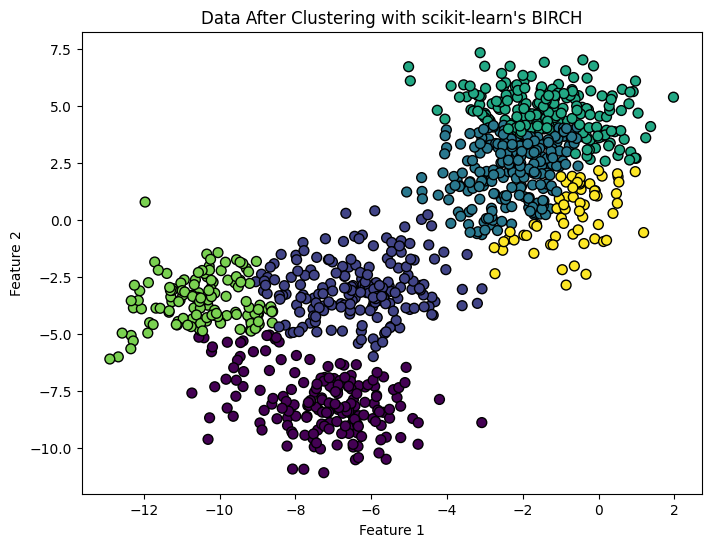

Execution time for SklearnBirch:  0.3026 seconds


In [ ]:
# Section 3

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import time
from scipy.io import arff
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import Birch as SklearnBirch
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs

class CFEntry:
    """
    Clustering Feature (CF) Entry class to store statistics about data points within a node.
    """

    def __init__(self, point):
        """
        Initialize a CFEntry with a data point.

        Args:
            point (numpy.ndarray): Data point.
        """
        self.n = 1
        self.LS = point  # Linear Sum
        self.SS = np.square(point)  # Squared Sum

    def update(self, point):
        """
        Update the CFEntry with a new data point.

        Args:
            point (numpy.ndarray): New data point to update the entry.
        """
        self.n += 1
        self.LS += point
        self.SS += np.square(point)

    def merge(self, other):
        """
        Merge this CFEntry with another CFEntry.

        Args:
            other (CFEntry): Another CFEntry to merge with.
        """
        self.n += other.n
        self.LS += other.LS
        self.SS += other.SS

    def centroid(self):
        """
        Calculate the centroid of the CFEntry.

        Returns:
            numpy.ndarray: Centroid of the CFEntry.
        """
        return self.LS / self.n

class CFNode:
    """
    Clustering Feature (CF) Node class to represent a node in the BIRCH tree.
    """

    def __init__(self, threshold, max_entries):
        """
        Initialize a CFNode with a threshold and maximum number of entries.

        Args:
            threshold (float): Threshold for splitting or merging nodes.
            max_entries (int): Maximum number of entries a node can hold.
        """
        self.threshold = threshold
        self.max_entries = max_entries
        self.entries = []
        self.child_nodes = []

    def insert(self, entry):
        if len(self.entries) < self.max_entries:
            self.entries.append(entry)
        else:
            if not self.child_nodes:
                self.child_nodes.append(CFNode(self.threshold, self.max_entries))
                self.child_nodes[-1].insert(entry)  # Insert the entry into the newly created child node
            else:
                closest_node = min(self.child_nodes, key=lambda n: np.linalg.norm(n.entries[0].centroid() - entry.centroid()))
                if np.linalg.norm(closest_node.entries[0].centroid() - entry.centroid()) < self.threshold:
                    closest_node.insert(entry)
                else:
                    self.child_nodes.append(CFNode(self.threshold, self.max_entries))
                    self.child_nodes[-1].insert(entry)

    def centroid(self):
        """
        Calculate the centroid of the CFNode.

        Returns:
            numpy.ndarray: Centroid of the CFNode.
        """
        if self.child_nodes:
            # Compute centroid based on child nodes' centroids
            child_centroids = [child.centroid() for child in self.child_nodes]
            return np.mean(child_centroids, axis=0)
        elif self.entries:
            # Compute centroid based on entries
            entry_centroids = [entry.centroid() for entry in self.entries]
            return np.mean(entry_centroids, axis=0)
        else:
            # Return None if the node is empty
            return None

class BIRCH:
    """
    BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) clustering algorithm.
    """

    def __init__(self, threshold, max_entries, branching_factor):
        """
        Initialize the BIRCH algorithm with threshold, maximum entries, and branching factor.

        Args:
            threshold (float): Threshold for splitting or merging nodes.
            max_entries (int): Maximum number of entries a node can hold.
            branching_factor (int): Number of subclusters to merge during clustering.
        """
        self.threshold = threshold
        self.max_entries = max_entries
        self.branching_factor = branching_factor
        self.root = None

    def fit(self, X):
        """
        Fit the BIRCH algorithm to the input data.

        Args:
            X (numpy.ndarray): Input data points.
        """
    def fit(self, X):
        self.root = CFNode(self.threshold, self.max_entries)
        for point in X:
          entry = CFEntry(point)
          self.root.insert(entry)

    def fit_hierarchical(self, X):
        """
        Fit the BIRCH algorithm hierarchically to the input data.

        This method creates a hierarchical BIRCH tree to represent the data.

        Args:
            X (numpy.ndarray): Input data points.
        """
        for point in X:
            entry = CFEntry(point)
            if self.root is None:
                self.root = CFNode(self.threshold, self.max_entries)
                self.root.insert(entry)
            else:
                self._fit_hierarchical_recursive(self.root, entry)

    def _fit_hierarchical_recursive(self, node, entry):
        """
        Recursively insert an entry into the hierarchical BIRCH tree.

        Args:
            node (CFNode): Current CFNode in the tree.
            entry (CFEntry): CFEntry to insert.
        """
        if not node.child_nodes and not node.entries:
            # The node is empty, insert the entry directly
            node.insert(entry)
        else:
            # Compute the centroids for comparison
            node_centroid = node.centroid()
            entry_centroid = entry.centroid()

            if node_centroid is not None and entry_centroid is not None:
                distance = np.linalg.norm(node_centroid - entry_centroid)

                if distance < self.threshold:
                    # If the distance is below the threshold, insert into the node
                    node.insert(entry)
                else:
                    # Otherwise, create a new child node and insert the entry into it
                    new_node = CFNode(self.threshold, self.max_entries)
                    new_node.insert(entry)
                    node.child_nodes.append(new_node)
            else:
                # Handle the case where centroids cannot be computed (empty nodes)
                node.insert(entry)

    def _get_clusters_recursive(self, node):
        """
        Recursively retrieve clusters from the hierarchical BIRCH tree.

        Args:
            node (CFNode): Current CFNode in the tree.

        Returns:
            list: List of cluster centroids.
        """
        clusters = [entry.centroid() for entry in node.entries]
        for child_node in node.child_nodes:
            clusters.extend(self._get_clusters_recursive(child_node))
        return clusters

    def get_clusters(self):
        """
        Get cluster centroids from the hierarchical BIRCH tree.

        Returns:
            list: List of cluster centroids.
        """
        return self._get_clusters_recursive(self.root)

    def get_labels(self, X):
        """
        Assigns a cluster label to each data point in X.

        Args:
            X (numpy.ndarray): Input data points.

        Returns:
            numpy.ndarray: Array of cluster labels for each data point.
        """
        labels = np.zeros(len(X), dtype=int)

        for i, point in enumerate(X):
            labels[i] = self._find_closest_cluster_label(point)

        return labels

    def _find_closest_cluster_label(self, point):
        """
        Finds the closest cluster for a given data point.

        Args:
            point (numpy.ndarray): A single data point.

        Returns:
            int: The label of the closest cluster.
        """
        min_distance = float('inf')
        closest_cluster_label = -1

        for cluster_label, node in enumerate(self._get_all_nodes(self.root)):
            centroid = node.centroid()
            if centroid is not None:
                distance = np.linalg.norm(centroid - point)
                if distance < min_distance:
                    min_distance = distance
                    closest_cluster_label = cluster_label

        return closest_cluster_label

    def _get_all_nodes(self, node):
        """
        Retrieves all nodes (leaves and intermediate) in the BIRCH tree.

        Args:
            node (CFNode): Starting node for the traversal.

        Returns:
            Generator[CFNode]: A generator that yields all nodes in the tree.
        """
        if node.child_nodes:
            for child in node.child_nodes:
                yield from self._get_all_nodes(child)
        else:
            yield node

def plot_clusters(X, labels, centroids=None, title="Clusters"):
    # Generate a large list of distinct colors
    colors = plt.cm.get_cmap('tab20', np.unique(labels).size).colors
    custom_cmap = ListedColormap(colors)

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)

    if centroids is not None:
        centroids = np.array(centroids)  # Convert centroids to a NumPy array
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Generate synthetic clustering data
random_state = 1
X, _ = make_blobs(n_samples=1000, centers=6, cluster_std=1.2, random_state=random_state)

# Load data from the ARFF file instead of generating data
#data, meta = load_arff_from_github('spherical_4_3.arff')

# Convert the data to a NumPy array
#X = np.array([[row[0], row[1]] for row in data])

# Plot before applying the algorithm
plot_clusters(X, labels=np.zeros(X.shape[0]), title="Data Before Clustering")

# Apply the CFTree BIRCH algorithm
start_time = time.time()
birch = BIRCH(threshold=10.6, max_entries=175, branching_factor=6)
birch.fit_hierarchical(X)
# Get cluster labels
labels = birch.get_labels(X)
# Extract centroids
# centroids = birch.get_clusters()
end_time = time.time()

# Execution time
execution_time = end_time - start_time

# Plot after applying the algorithm
print()
plot_clusters(X, labels, title="Data After Clustering with BIRCH CFTree")
print("=====================================================================================")
print(f"Execution time: {execution_time: .4f} seconds")

# Apply the Simple BIRCH algorithm
start_time_2 = time.time()
birch_2 = SimpleBIRCH(threshold=2, branching_factor=6)
birch_2.fit(X)
labels = birch_2.predict(X)
end_time_2 = time.time()

# Execution time
execution_time_2 = end_time_2 - start_time_2

# Extract centroids
centroids_2 = np.array([cluster.centroid for cluster in birch_2.clusters])

# Plot after applying the algorithm
print()
plot_clusters(X, labels, centroids=centroids_2, title="Data After Clustering with Simple BIRCH")
print("====================================================================================")
print(f"Execution time for SimpleBirch: {execution_time_2: .4f} seconds")
print()

# Apply scikit-learn's BIRCH algorithm
start_time_3 = time.time()
sklearn_birch = SklearnBirch(threshold=0.25, branching_factor=3, n_clusters = 6)
sklearn_birch.fit(X)
sklearn_labels = sklearn_birch.predict(X)
end_time_3 = time.time()
execution_time_3 = end_time_3 - start_time_3

# Plot after applying scikit-learn's BIRCH
plot_clusters(X, sklearn_labels, title="Data After Clustering with scikit-learn's BIRCH")
print("====================================================================================")
print(f"Execution time for SklearnBirch: {execution_time_3: .4f} seconds")